In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 实现了：
# 1.模拟多种类型verifier（诚实，非诚实，精明的非诚实）执行验证，输出验证成功率和它们的信誉值变化情况并绘图
# 2.实现了在系统启动初期 限制信誉值的增长（但可以下降）
# 3.实现了自动剔除低于信誉值阈值的verifier

# 随机种子设置
def set_seed(seed):
    np.random.seed(seed)  # numpy产生的随机数一致

set_seed(61)

In [2]:
def simulate_verifier_groups(
    n_epochs,
    lambda_,
    window_size,
    n_verifiers,
    proportions,
    group_size,
    attack_start,
):
    # Initialize verifiers
    types = ["honest", "Free-rider", "Malicious"]
    verifiers = []
    for i, proportion in enumerate(proportions):
        for _ in range(int(n_verifiers * proportion)):
            verifiers.append(
                {
                    "type": types[i],
                    "reputation": 0.5,
                    "history": [],
                    "active": True,  # Indicator to check if verifier is still active
                }
            )

    # Simulation over epochs
    average_reputations = {'honest': [], 'Free-rider': [], 'Malicious': []}
    stddev_reputations = {'honest': [], 'Free-rider': [], 'Malicious': []}

    # 使用优化算法获取特定数量满足要求的委员会
    for epoch in range(n_epochs):
        # 将信誉值大于阈值的verifier随机分组
        np.random.shuffle(verifiers)
        active_verifiers = [
            v for v in verifiers if v["active"]
        ]  # Only consider active verifiers
        groups = [
            active_verifiers[i : i + group_size]
            for i in range(0, len(active_verifiers), group_size)
        ]

        # 对于每一组，判断其是否验证成功
        for group in groups:
            results = []
            for verifier in group:
                if verifier["type"] == "honest":
                    result = 1 if np.random.rand() > 0.01 else 0  # 90% success rate
                elif verifier["type"] == "Free-rider":
                    result = 0 if np.random.rand() > 0.1 else 1  # 10% success rate
                else:  # smart_dishonest
                    if epoch < attack_start:
                        result = 1 if np.random.rand() > 0.01 else 0  # 90% success rate
                    else:
                        result = 0  # Always fail after attack start

                results.append(result)
                verifier["history"].append(result)

            # Update reputations and deactivate low-reputation verifiers
            for verifier in group:
                weights = np.exp(
                    -lambda_ * np.arange(1, len(verifier["history"]) + 1)[::-1]
                )
                verifier["reputation"] = np.dot(
                    verifier["history"][-window_size:], weights[-window_size:]
                ) / np.sum(weights[-window_size:])
                # 在系统启动初期 限制信誉值的增长（但可以下降）
                if epoch < window_size and verifier["reputation"] > 0.5:
                    verifier["reputation"] = 0.5

        # Calculate and store average reputation and standard deviation for each type
        for verifier_type in average_reputations.keys():
            type_verifiers = [
                v["reputation"] for v in verifiers if v["type"] == verifier_type
            ]
            average_reputations[verifier_type].append(
                np.mean(type_verifiers) if type_verifiers else 0
            )
            stddev_reputations[verifier_type].append(
                np.std(type_verifiers) if type_verifiers else 0
            )

    return average_reputations, stddev_reputations

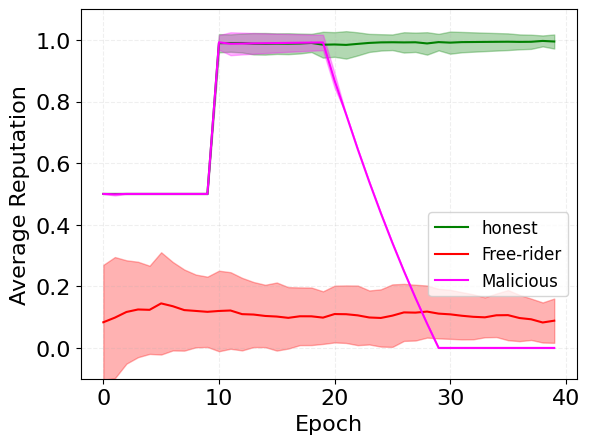

In [3]:
# Simulation settings
n_epochs = 40
lambda_ = 0.05
window_size = 10
n_verifiers = 100
group_size = 3
attack_start = 20


def eval(proportions):
    average_reputations, stddev_reputations = simulate_verifier_groups(
        n_epochs,
        lambda_,
        window_size,
        n_verifiers,
        proportions,
        group_size,
        attack_start,
    )
    torch.save(average_reputations,"./avg_rep")

    # Plot average reputation values for each verifier type
    plt.figure()
    plt.yticks(fontsize=16)
    plt.xticks(np.arange(0, 41, 10), fontsize=16)
    # for color, (verifier_type, avg_reps) in zip(
    #     ["g", "r", "fuchsia"], average_reputations.items()
    # ):
    #     stddev_reps = stddev_reputations[verifier_type]
    #     plt.plot(avg_reps, label=f"{verifier_type}", color=color)
    #     epochs = range(n_epochs)
    #     plt.fill_between(epochs, np.array(avg_reps) - np.array(stddev_reps), np.array(avg_reps) + np.array(stddev_reps), alpha=0.3)

    for color, verifier_type in zip(["g", "r", "fuchsia"], average_reputations.keys()):
        epochs = range(n_epochs)
        avg_reps = average_reputations[verifier_type]
        stddev_reps = stddev_reputations[verifier_type]
        plt.plot(
            epochs, avg_reps, label=f"{verifier_type}", color=color
        )
        plt.fill_between(
            epochs,
            np.array(avg_reps) - np.array(stddev_reps),
            np.array(avg_reps) + np.array(stddev_reps),
            alpha=0.3,
            color=color,
        )

    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Average Reputation", fontsize=16)
    plt.ylim(-0.1, 1.1)  # Set y-axis range to 0-1
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.2), fontsize=12)
    plt.grid(ls="--", alpha=0.2)
    plt.savefig(f"figures/reputation_avgrep.pdf", dpi=300, bbox_inches="tight")


eval([0.6, 0.3, 0.1])